# Travelling Salesman Problem
---
Description:

- Optimization (combinatorial)
- Single-objective
- Constraints (yes)
---

The travelling salesman problem, asks the following question: Given a list of cities and the distances between each
pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?


https://en.wikipedia.org/wiki/Travelling_salesman_problem

### First we import python libraries and set up the directory of our code.

In [1]:
import numpy as np
import os, sys, copy
import matplotlib.pyplot as plt
from collections import namedtuple

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [2]:
# Import main classes.
from star_pso.auxiliary.swarm import Swarm
from star_pso.auxiliary.utilities import BlockType
from star_pso.auxiliary.data_block import DataBlock
from star_pso.auxiliary.jat_particle import JatParticle
from star_pso.engines.jack_of_all_trades_pso import JackOfAllTradesPSO

### We create a small data sructure to hold the city information.

In [3]:
# Data structure to represent a city on a grid.
City = namedtuple("City", ["Name", "x", "y"])

### Then we create a list of cities on a grid with (x, y) coordinates.

In [4]:
# Define n_cities on a grid [0, 15] x [0, 15]
rome   = City("Rome"  , 3,  2)
athens = City("Athens", 7,  3)
lisbon = City("Lisbon", 14, 2)
madrid = City("Madrid", 3,  7)
berlin = City("Berlin", 12, 7)
paris  = City("Paris" , 2, 14)
london = City("London", 7, 12)
moscow = City("Moscow", 12,12)
dublin = City("Dublin", 6,  9)
cairo  = City("Cairo" , 10, 8)

# Put all the cities in a dictionary.
city_dict = {i: c for i, c in enumerate([rome, athens, lisbon, madrid, berlin,
                                         paris, london, moscow, dublin, cairo])}

### Lets plot the list.

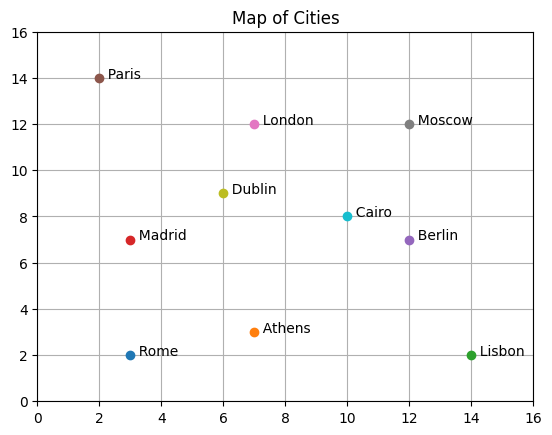

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for city in city_dict.values():
    ax.plot(city.x, city.y, 'o')
    ax.annotate(f'  {city.Name}', xy=(city.x, city.y))
# _end_for_

ax.grid()

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

plt.title("Map of Cities")
plt.show()

In [6]:
# Define the objective function.
def fun_TSP(x: np.typing.ArrayLike):
    """
    This function computes the total distance travelled from all cities.
    We assume (hard constraint) that the order that they cities appear
    in the genome list, is the same order the traveler is visiting them.

    When we reach the end of the list we make one extra calculation from
    the last entry of the list to the first: [-1] -> [0].
    """

    # Compute the distance.
    total_distance = 0.0

    # Get the size of the input vector.
    N = len(x)
    
    # Iterate through all the cities.
    for i, n in enumerate(x):
        
        # Get the n-th city in the list.
        city_a = city_dict[n]

        # NOTE: The next index ('j') should point at the
        # begining of the list, once we reach at the end.
        j = i + 1 if i < N-1 else 0

        # Get the next city in the list.
        city_b = city_dict[x[j]]

        # Extract their coordinates.
        x_a, y_a = city_a.x, city_a.y
        x_b, y_b = city_b.x, city_b.y

        # Compute the Euclidean distance.
        total_distance += np.sqrt((x_a - x_b)**2 + ((y_a - y_b)**2))
     
    # _end_for_

    # Condition for termination.
    solution_found = True if total_distance < 49.0 else False
    
    # Return the solution tuple.
    return -total_distance, solution_found
# _end_def_

## Important note

These types of problems (like the TSP) require special crossover/mutation operators for permutations, in order to avoid creating invalid offsprings. The requirement is that all the genes from the initial population have to be present exactly once in the offsprings.

In [11]:
# Define the number of particles.
N = 100

# Define the size of optimizing variables.
D = len(city_dict)

# Define the variable set for the
# categorical optimization variables.
var_set = list(city_dict.keys())

# Initial swarm population.
swarm_t0 = Swarm([JatParticle([DataBlock(np.ones(D)/D,
                                         BlockType.CATEGORICAL,
                                         valid_set=var_set) for _ in range(D)])
                  for _ in range(N)])

# Create the JackOfAllTradesPSO object that will carry on the optimization.
test_PSO = JackOfAllTradesPSO(initial_swarm = swarm_t0,
                              obj_func = fun_TSP,
                              permutation_mode = True)

In [12]:
test_PSO.run(max_it = 500,
             options = {"w": 0.7, "c1": 2.65, "c2": 2.85, "global_avg": False},
             reset_swarm = True,
             verbose = True)

Initial f_optimal = -75.1909
Iteration:     1 -> f_optimal = -62.0618
Iteration:    51 -> f_optimal = -49.9240
JackOfAllTradesPSO finished in 77 iterations.
Final f_optimal = -48.6814
run: elapsed time = 4.489 seconds.


### Display the final solution along with the plot of the cities visited.

In [13]:
# Extract the optimal solution from the PSO.
optimal_solution = test_PSO.swarm.best_particle()

# Display the (final) optimal value.
print(f"Minimum distance: {abs(optimal_solution.value)}\n")

Minimum distance: 48.68138249714835



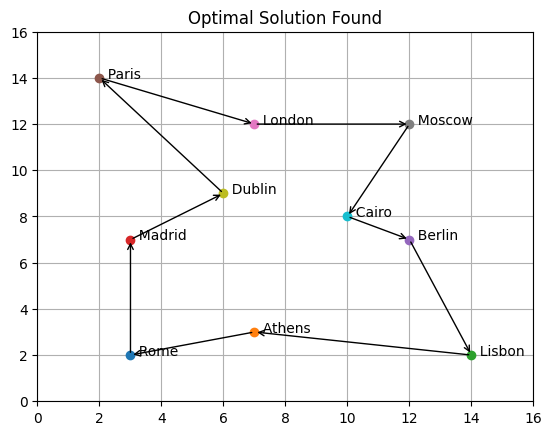

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

for city in city_dict.values():
    ax.plot(city.x, city.y, 'o')
    ax.annotate(f'  {city.Name}', xy=(city.x, city.y))
# _end_for_

best_solution = test_PSO.stats["x_best"][-1]

# Get the size of the JatParticle.
N = len(best_solution)

# Iterate through all the cities.
for i, n in enumerate(best_solution):

    city_a = city_dict[n]

    # The next index 'j' should point at the
    # begining of the list, once we reach the end.
    j = i + 1 if i < N-1 else 0

    # Get the next city in the list.
    city_b = city_dict[best_solution[j]]

    # Extract their coordinates.
    x_a, y_a = city_a.x, city_a.y
    x_b, y_b = city_b.x, city_b.y

    # Put the arrow directions.
    ax.annotate("", xy=(x_a, y_a), xytext=(x_b, y_b),
                arrowprops=dict(arrowstyle="<-"))
# _end_for_

ax.grid()

ax.set_xlim([0, 16])
ax.set_ylim([0, 16])

plt.title("Optimal Solution Found")
plt.show()